In [1]:
import numpy as np
import warnings, scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
from datetime import datetime as dt
import dateutil
from scipy.optimize import curve_fit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings("ignore")


In [68]:
!pip freeze > requirements.txt

# Limpieza y Transformacion

Cambiar las columnas Vlo-I y Vlo-O a string, habia mas de un tipo dentro de la columna

In [2]:
dtypes = {'Vlo-I':str,'Vlo-O':str }

Leer dataframe, convertir Fecha-I y Fecha-O a datetime 

In [3]:
df = pd.read_csv("dataset_SCL.csv", parse_dates=['Fecha-I', 'Fecha-O'],dtype=dtypes)

In [4]:
df['ANO'] = df['AÑO']
df.drop('AÑO',axis='columns', inplace=True)

Ningun campo esta vacio o tiene valores nulos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int64         
 11  MES        68206 non-null  int64         
 12  DIANOM     68206 non-null  object        
 13  TIPOVUELO  68206 non-null  object        
 14  OPERA      68206 non-null  object        
 15  SIGLAORI   68206 non-null  object        
 16  SIGLADES   68206 non-null  object       

In [6]:
df2 = df.set_index('Fecha-I')

Observar cuantas aerolineas son

In [7]:
df.OPERA.value_counts(normalize=True)

Grupo LATAM                 0.599537
Sky Airline                 0.209630
Aerolineas Argentinas       0.028575
Copa Air                    0.027124
Latin American Wings        0.024543
Avianca                     0.016890
JetSmart SPA                0.016054
Gol Trans                   0.011817
American Airlines           0.011099
Air Canada                  0.008284
Iberia                      0.005307
Delta Air                   0.005249
Air France                  0.005249
Aeromexico                  0.005146
United Airlines             0.004912
Oceanair Linhas Aereas      0.004091
Alitalia                    0.003797
K.L.M.                      0.003680
British Airways             0.003006
Qantas Airways              0.002859
Lacsa                       0.001349
Austral                     0.001085
Plus Ultra Lineas Aereas    0.000718
Name: OPERA, dtype: float64

In [8]:
global_stats = df.OPERA.value_counts()
global_stats

Grupo LATAM                 40892
Sky Airline                 14298
Aerolineas Argentinas        1949
Copa Air                     1850
Latin American Wings         1674
Avianca                      1152
JetSmart SPA                 1095
Gol Trans                     806
American Airlines             757
Air Canada                    565
Iberia                        362
Delta Air                     358
Air France                    358
Aeromexico                    351
United Airlines               335
Oceanair Linhas Aereas        279
Alitalia                      259
K.L.M.                        251
British Airways               205
Qantas Airways                195
Lacsa                          92
Austral                        74
Plus Ultra Lineas Aereas       49
Name: OPERA, dtype: int64

Crear columna Booleana para temporada alta

In [9]:
df['temporada_alta'] = df['Fecha-I'].apply(lambda x: 1 if ((x> dt(2016,12,15)
 and x<dt(2017,3,3)) or (x>dt(2017,7,15) and x<dt(2017,7,31)) or ( x>dt(2017,9,11)
 and x<dt(2017,9,30))) else 0)

Crear columnas diferencia de minutos y atraso_15 min

In [10]:
df['dif_min'] = df['Fecha-O'] - df['Fecha-I']
df['dif_min'] = df['dif_min'].apply(lambda x: x.total_seconds()/60)
df['atraso_15'] = df['dif_min'].apply(lambda x: 1 if x>15 else 0)

Diccionario para mapear la hora del dia

In [11]:
periodo = {0:'noche',1:'noche', 2:'noche', 3:'noche', 4:'noche'
, 5:'manana', 6:'manana', 7:'manana', 8:'manana', 9:'manana'
, 10:'manana', 11:'manana', 12:'tarde', 13:'tarde', 14:'tarde'
, 15:'tarde', 16:'tarde', 17:'tarde', 18:'tarde', 19:'noche'
, 20:'noche', 21:'noche', 22:'noche', 23:'noche', 24:'noche'}

Crear columna periodo_dia

In [12]:
df['periodo_dia'] = df['Fecha-I'].dt.hour
df['periodo_dia'] = df['periodo_dia'].map(periodo)

# Exploratory Data Analysis

Observar como estan distribuidos por periodo_dia y numero de records

In [13]:
df.periodo_dia.value_counts()

tarde     25506
manana    25352
noche     17348
Name: periodo_dia, dtype: int64

<AxesSubplot:xlabel='periodo_dia', ylabel='count'>

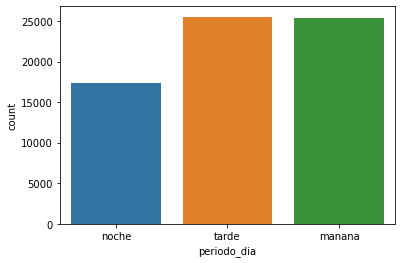

In [14]:
sns.countplot(x=df.periodo_dia)

In [15]:
df.atraso_15.value_counts(normalize=True)

0    0.81506
1    0.18494
Name: atraso_15, dtype: float64

In [16]:
df3 = df[['OPERA', 'Emp-O']]
df3 = df3.set_index('Emp-O')['OPERA'].to_dict()

In [17]:
df3

{'AAL': 'American Airlines',
 'ACA': 'Air Canada',
 'AFR': 'Air France',
 'AMX': 'Aeromexico',
 'ARG': 'Aerolineas Argentinas',
 'AUT': 'Austral',
 'AVA': 'Avianca',
 'AZA': 'Alitalia',
 'BAW': 'British Airways',
 'CMP': 'Copa Air',
 'DAL': 'Delta Air',
 'GLO': 'Gol Trans',
 'IBE': 'Iberia',
 'KLM': 'K.L.M.',
 'LRC': 'Lacsa',
 'QFA': 'Qantas Airways',
 'UAL': 'United Airlines',
 'LAP': 'Grupo LATAM',
 'TAM': 'Grupo LATAM',
 'SKU': 'Sky Airline',
 'LAN': 'Grupo LATAM',
 'LXP': 'Grupo LATAM',
 'LNE': 'Grupo LATAM',
 'LPE': 'Grupo LATAM',
 'DSM': 'Grupo LATAM',
 '48O': 'Latin American Wings',
 '56R': 'Latin American Wings',
 'JMR': 'Latin American Wings',
 'PUE': 'Plus Ultra Lineas Aereas',
 'JAT': 'JetSmart SPA',
 'TPU': 'Avianca',
 'ONE': 'Oceanair Linhas Aereas'}

In [18]:
df2 = df.loc[:, ['OPERA', 'dif_min']]
df2['OPERA'] = df2['OPERA'].replace(df3)

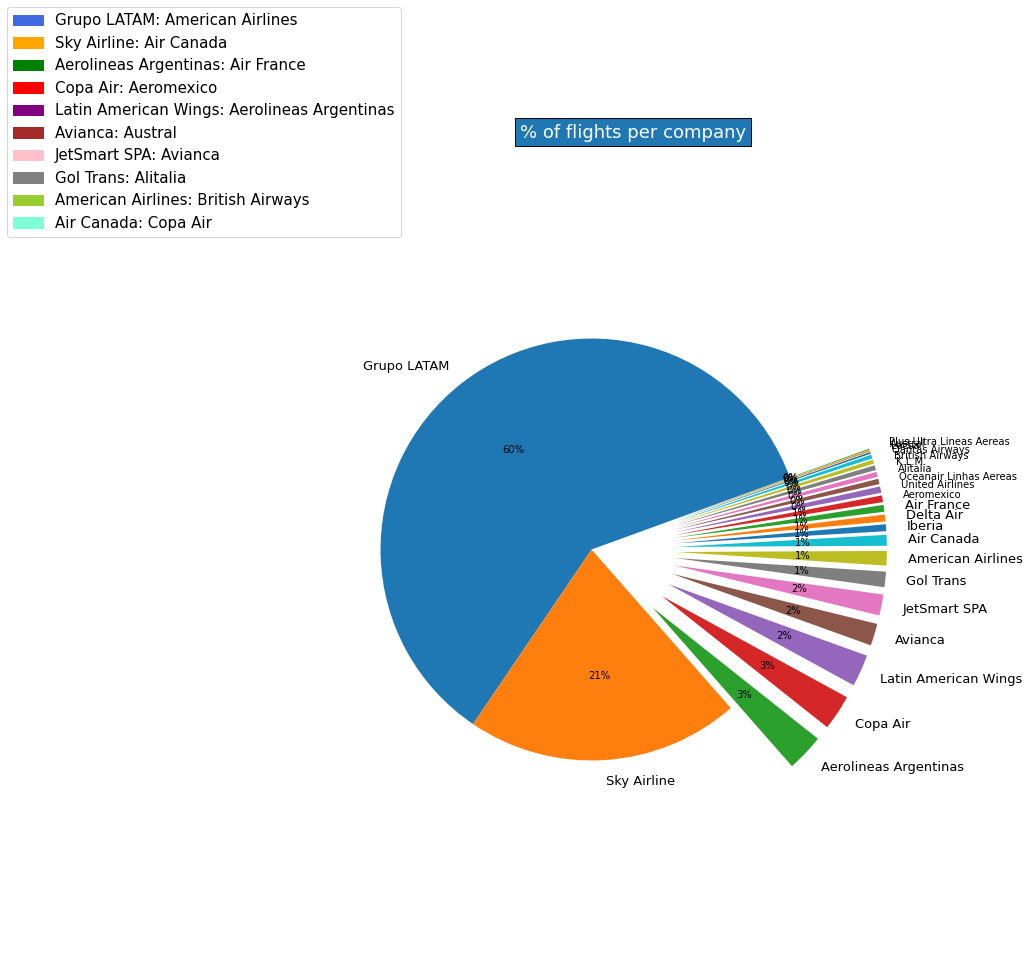

In [19]:
fig = plt.figure(1, figsize=(10,15))
ax1=fig.subplots() 


labels = [s for s in  global_stats.index[:]]
sizes  = global_stats.values[:]
explode = [0.0 if sizes[i] > 2000 else 0.4 for i in range(len(df.OPERA.unique()[:]))]
patches, texts, autotexts = ax1.pie(sizes,
                    labels=labels,explode=explode,  autopct='%1.0f%%',
                    shadow=False, startangle=20)

for i in range(len(df.OPERA.unique()[:])): 
    texts[i].set_fontsize(10)
for i in range(len(df.OPERA.unique()[10:])): 
     texts[i].set_fontsize(13)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'pad':5},
              color = 'w',fontsize=18)
colors = ['royalblue', 'orange', 'green', 'r', 'purple', 'brown', 'pink',
          'gray', 'yellowgreen', 'aquamarine']
comp_handler = []
for i in range(len(df.OPERA.unique()[:10])):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + df.OPERA.unique()[i]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
    fontsize = 15, bbox_transform=plt.gcf().transFigure, loc=5)

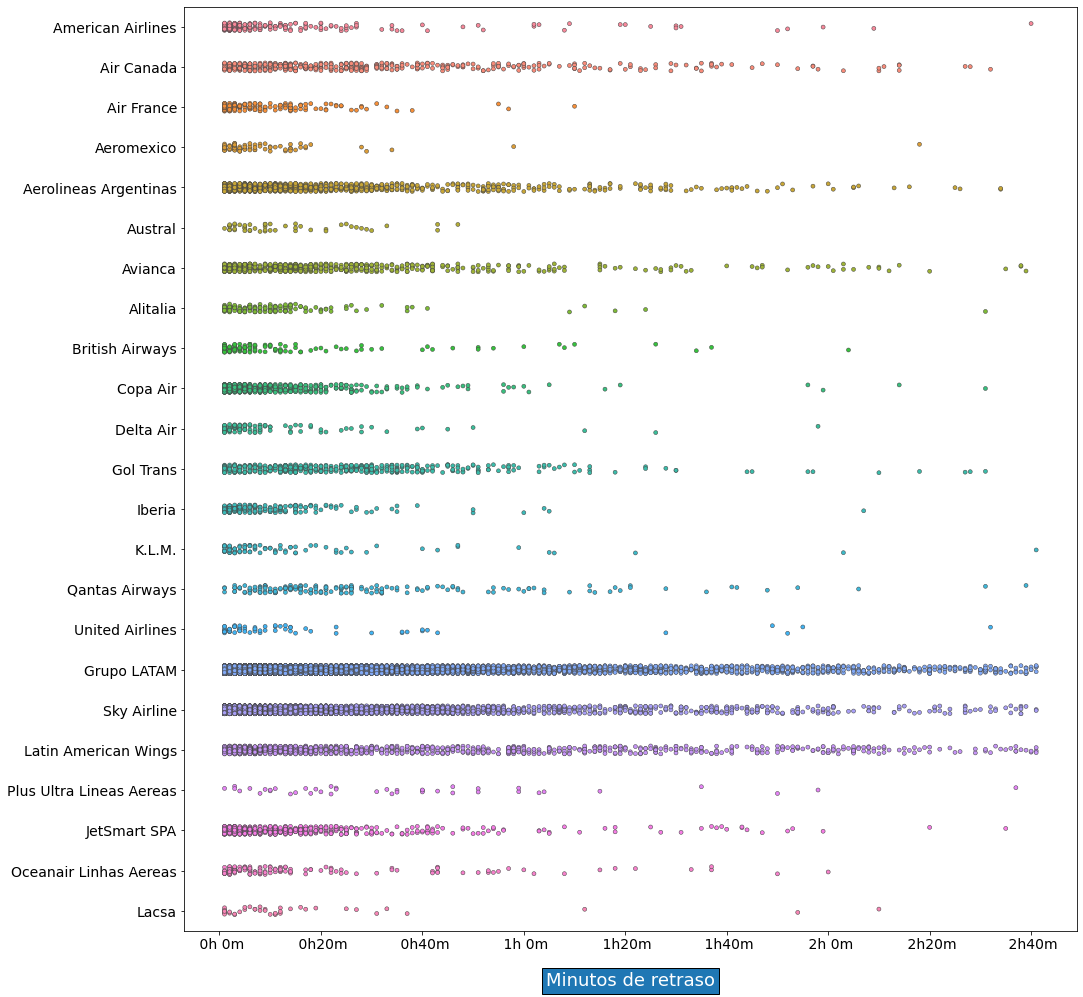

In [20]:
fig = plt.figure(1, figsize=(16,17))
ax3=fig.subplots()
sns.stripplot(y="OPERA", x="dif_min", size = 4,
                    data=df[df.dif_min>0], linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Minutos de retraso', fontsize=18, bbox={},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

# ASDF ASDF

In [21]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA',
       'SIGLAORI', 'SIGLADES', 'ANO', 'temporada_alta', 'dif_min', 'atraso_15',
       'periodo_dia'],
      dtype='object')

In [22]:
# labels = [df3[item.get_text()] for item in ax.get_yticklabels()]
# df3[it]

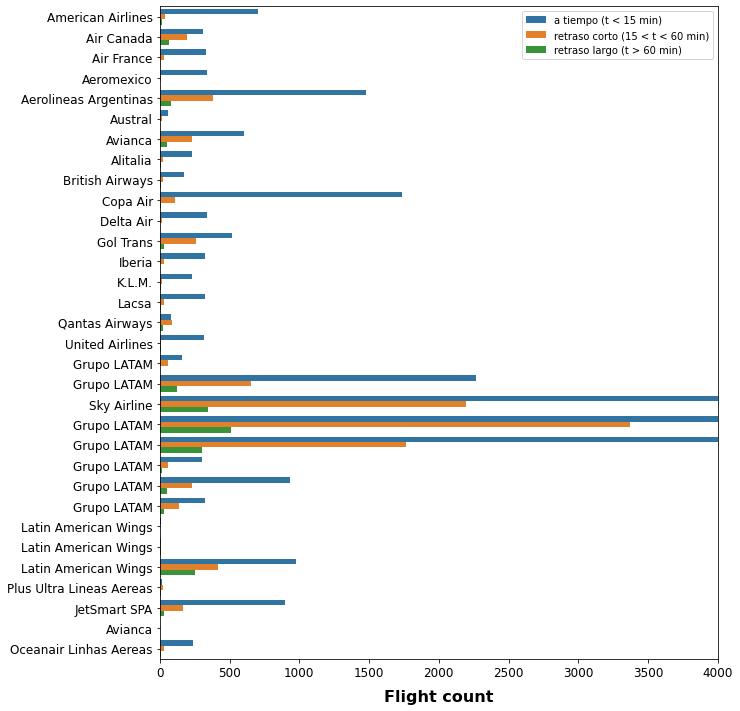

In [23]:
delay_type = lambda x:((0,1)[x > 15],2)[x > 60]

df['dif_nivel'] = df['dif_min'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,12))
ax = sns.countplot(y="Emp-O", hue='dif_nivel', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [df3[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0)
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'normal', rotation = 0)
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
plt.xlim([0,4000])
L = plt.legend()
L.get_texts()[0].set_text('a tiempo (t < 15 min)')
L.get_texts()[1].set_text('retraso corto (15 < t < 60 min)')
L.get_texts()[2].set_text('retraso largo (t > 60 min)')
plt.show()



In [24]:
df.dif_nivel.value_counts(normalize=True)

0    0.815060
1    0.155895
2    0.029044
Name: dif_nivel, dtype: float64

In [25]:
df.atraso_15.value_counts()

0    55592
1    12614
Name: atraso_15, dtype: int64

In [26]:
global_stats

Grupo LATAM                 40892
Sky Airline                 14298
Aerolineas Argentinas        1949
Copa Air                     1850
Latin American Wings         1674
Avianca                      1152
JetSmart SPA                 1095
Gol Trans                     806
American Airlines             757
Air Canada                    565
Iberia                        362
Delta Air                     358
Air France                    358
Aeromexico                    351
United Airlines               335
Oceanair Linhas Aereas        279
Alitalia                      259
K.L.M.                        251
British Airways               205
Qantas Airways                195
Lacsa                          92
Austral                        74
Plus Ultra Lineas Aereas       49
Name: OPERA, dtype: int64

In [27]:
df3

{'AAL': 'American Airlines',
 'ACA': 'Air Canada',
 'AFR': 'Air France',
 'AMX': 'Aeromexico',
 'ARG': 'Aerolineas Argentinas',
 'AUT': 'Austral',
 'AVA': 'Avianca',
 'AZA': 'Alitalia',
 'BAW': 'British Airways',
 'CMP': 'Copa Air',
 'DAL': 'Delta Air',
 'GLO': 'Gol Trans',
 'IBE': 'Iberia',
 'KLM': 'K.L.M.',
 'LRC': 'Lacsa',
 'QFA': 'Qantas Airways',
 'UAL': 'United Airlines',
 'LAP': 'Grupo LATAM',
 'TAM': 'Grupo LATAM',
 'SKU': 'Sky Airline',
 'LAN': 'Grupo LATAM',
 'LXP': 'Grupo LATAM',
 'LNE': 'Grupo LATAM',
 'LPE': 'Grupo LATAM',
 'DSM': 'Grupo LATAM',
 '48O': 'Latin American Wings',
 '56R': 'Latin American Wings',
 'JMR': 'Latin American Wings',
 'PUE': 'Plus Ultra Lineas Aereas',
 'JAT': 'JetSmart SPA',
 'TPU': 'Avianca',
 'ONE': 'Oceanair Linhas Aereas'}

In [28]:
df4 = df[['OPERA', 'Emp-O']]
df4 = df4.set_index('Emp-O')['OPERA'].to_dict()

In [29]:
df4

{'AAL': 'American Airlines',
 'ACA': 'Air Canada',
 'AFR': 'Air France',
 'AMX': 'Aeromexico',
 'ARG': 'Aerolineas Argentinas',
 'AUT': 'Austral',
 'AVA': 'Avianca',
 'AZA': 'Alitalia',
 'BAW': 'British Airways',
 'CMP': 'Copa Air',
 'DAL': 'Delta Air',
 'GLO': 'Gol Trans',
 'IBE': 'Iberia',
 'KLM': 'K.L.M.',
 'LRC': 'Lacsa',
 'QFA': 'Qantas Airways',
 'UAL': 'United Airlines',
 'LAP': 'Grupo LATAM',
 'TAM': 'Grupo LATAM',
 'SKU': 'Sky Airline',
 'LAN': 'Grupo LATAM',
 'LXP': 'Grupo LATAM',
 'LNE': 'Grupo LATAM',
 'LPE': 'Grupo LATAM',
 'DSM': 'Grupo LATAM',
 '48O': 'Latin American Wings',
 '56R': 'Latin American Wings',
 'JMR': 'Latin American Wings',
 'PUE': 'Plus Ultra Lineas Aereas',
 'JAT': 'JetSmart SPA',
 'TPU': 'Avianca',
 'ONE': 'Oceanair Linhas Aereas'}

In [30]:
global_stats.index

Index(['Grupo LATAM', 'Sky Airline', 'Aerolineas Argentinas', 'Copa Air',
       'Latin American Wings', 'Avianca', 'JetSmart SPA', 'Gol Trans',
       'American Airlines', 'Air Canada', 'Iberia', 'Delta Air', 'Air France',
       'Aeromexico', 'United Airlines', 'Oceanair Linhas Aereas', 'Alitalia',
       'K.L.M.', 'British Airways', 'Qantas Airways', 'Lacsa', 'Austral',
       'Plus Ultra Lineas Aereas'],
      dtype='object')

In [31]:
for carrier_name in [df4[x] for x in global_stats.index]:
    print(carrier_name)

KeyError: 'Grupo LATAM'

In [44]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA',
       'SIGLAORI', 'SIGLADES', 'ANO', 'temporada_alta', 'dif_min', 'atraso_15',
       'periodo_dia', 'dif_nivel', 'Season'],
      dtype='object')

In [45]:
global_stats.index

Index(['Grupo LATAM', 'Sky Airline', 'Aerolineas Argentinas', 'Copa Air',
       'Latin American Wings', 'Avianca', 'JetSmart SPA', 'Gol Trans',
       'American Airlines', 'Air Canada', 'Iberia', 'Delta Air', 'Air France',
       'Aeromexico', 'United Airlines', 'Oceanair Linhas Aereas', 'Alitalia',
       'K.L.M.', 'British Airways', 'Qantas Airways', 'Lacsa', 'Austral',
       'Plus Ultra Lineas Aereas'],
      dtype='object')

In [59]:
# for carrier_name in [df3[x] for x in global_stats.index]:
#     print(carrier_name)

In [60]:
global_stats2 = df['Emp-O'].value_counts()
global_stats2

LAN    20988
LXP    14558
SKU    14298
TAM     3046
ARG     1946
CMP     1850
JMR     1647
LPE     1214
JAT     1095
AVA      885
GLO      806
AAL      757
ACA      565
DSM      493
LNE      374
IBE      362
AFR      358
DAL      358
LRC      357
AMX      351
UAL      335
ONE      279
AZA      259
KLM      251
LAP      219
BAW      205
QFA      195
AUT       77
PUE       49
56R       17
48O       10
TPU        2
Name: Emp-O, dtype: int64

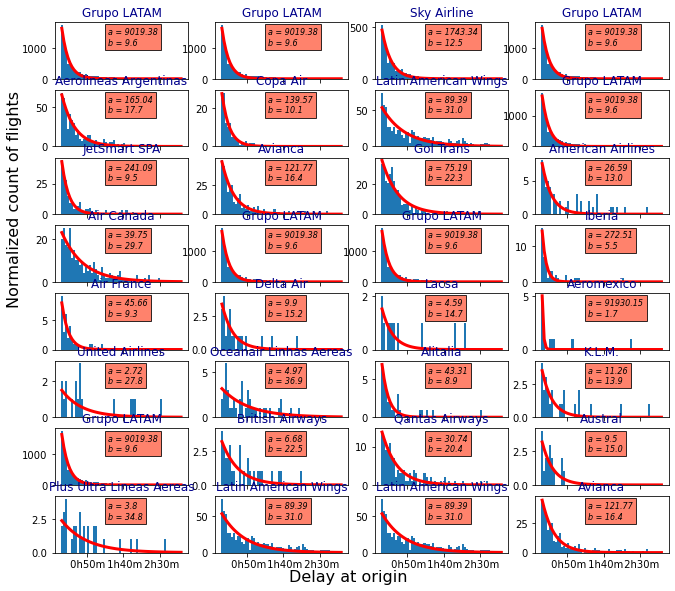

In [48]:
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [df4[x] for x in global_stats2.index]:
    i += 1
    ax = fig.add_subplot(9,4,i)
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df[df['OPERA']==carrier_name]['dif_min'],
            range = (15,180), bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________ bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)  
    
#     # define tick labels for each subplot
    if i < 29:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
#     #______________
#     # subplot title
    plt.title(carrier_name, fontsize = 12, fontweight = 'normal', color = 'darkblue')
#     #____________
#     # axes labels 
    if i == 1:
        ax.text(-0.30,-4,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 30:
        ax.text( 1, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
#     #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.4, 0.6, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 8,
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':3})
    
plt.tight_layout()
    

In [49]:
identify_airporto = df.set_index('Ori-O')['SIGLAORI'].to_dict() #origen
identify_airportd = df.set_index('Des-O')['SIGLADES'].to_dict() #destino

In [50]:
identify_airportd

{'KMIA': 'Miami',
 'KDFW': 'Dallas',
 'SAEZ': 'Buenos Aires',
 'CYYZ': 'Toronto',
 'LFPG': 'Paris',
 'MMMX': 'Ciudad de Mexico',
 'SABE': 'Buenos Aires',
 'SKBO': 'Bogota',
 'LIRF': 'Roma',
 'EGLL': 'Londres',
 'MPTO': 'Ciudad de Panama',
 'KATL': 'Atlanta',
 'SBGR': 'Sao Paulo',
 'SBGL': 'Rio de Janeiro',
 'SBFL': 'Florianapolis',
 'LEMD': 'Madrid',
 'SPJC': 'Lima',
 'YSSY': 'Sydney',
 'KIAH': 'Houston',
 'SGAS': 'Asuncion',
 'SBFI': 'Cataratas Iguacu',
 'SCTE': 'Puerto Montt',
 'SCCI': 'Punta Arenas',
 'SCNT': 'Puerto Natales',
 'SCBA': 'Balmaceda',
 'SCQP': 'Temuco',
 'SCVD': 'Valdivia',
 'SCIE': 'Concepcion',
 'SCSE': 'La Serena',
 'SCAT': 'Copiapo',
 'SCCF': 'Calama',
 'SCFA': 'Antofagasta',
 'SCDA': 'Iquique',
 'SCAR': 'Arica',
 'SAME': 'Mendoza',
 'SACO': 'Cordoba',
 'SUMU': 'Montevideo',
 'SCPQ': 'Castro (Chiloe)',
 'SCJO': 'Osorno',
 'KMCO': 'Orlando',
 'KJFK': 'Nueva York',
 'SEGU': 'Guayaquil',
 'MMUN': 'Cancun',
 'MDPC': 'Punta Cana',
 'KLAX': 'Los Angeles',
 'NZAA': 'Auckl

In [51]:
#_________________________________________________________________
# We select the company and create a subset of the main dataframe
df5 = df[['Ori-I','Des-O','dif_min']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df5.iterrows():
    if pd.isnull(col['dif_min']): continue
    route = str(col['Ori-I'])+'-'+str(col['Des-O'])
    if route in trajet.keys():
        trajet[route].append(col['dif_min'])
    else:
        trajet[route] = [col['dif_min']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()

ksdjfksjdf sdf

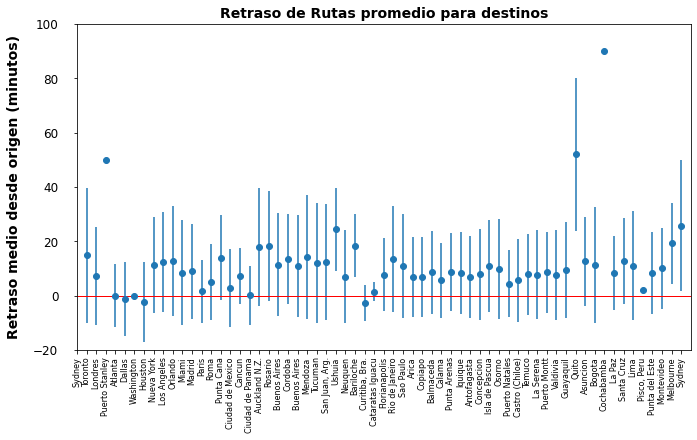

In [52]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[1]
    x_label.append(identify_airportd[index]) 
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(11,6))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = std_val, fmt='o') 
ax.set_title('Retraso de Rutas promedio para destinos',
             fontsize=14, weight = 'bold')
plt.ylabel('Retraso medio desde origen (minutos)', fontsize=14, weight = 'bold', labelpad=12)

imin, imax = -1, 63
plt.xlim(imin, imax) ; plt.ylim(-20, 100)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)



ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)
plt.hlines(y= 0, xmin=-1, xmax= 70, color='red', linestyle ='-', linewidth = 1)
plt.show()

In [53]:
df[df.SIGLADES == 'Cochabamba']

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,OPERA,SIGLAORI,SIGLADES,ANO,temporada_alta,dif_min,atraso_15,periodo_dia,dif_nivel,Season
67692,2017-12-10 00:01:00,1238,SCEL,SLCB,LAN,2017-12-10 01:54:00,1238.0,SCEL,SLCB,LAN,...,Grupo LATAM,Santiago,Cochabamba,2017,0,113.0,1,noche,2,Otono


# See how Data is distributed among categories

In [54]:
df['Season'] = df['Fecha-I'].apply(lambda x: 'Invierno' if  (x > dt(2016,12,1) and x < dt(2017,3,1)) 
                                   else'Primavera' if (x> dt(2017,3,1) and x < dt(2017,6,1)) 
                                   else 'Verano' if (x> dt(2017,6,1) and x < dt(2017,11,1)) 
                                   else 'Otono' if (x> dt(2017,11,1) and x < dt(2018,1,15)) else 0)

In [55]:
df.Season.value_counts()

Verano       28359
Primavera    15740
Otono        12438
Invierno     11669
Name: Season, dtype: int64

In [56]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA',
       'SIGLAORI', 'SIGLADES', 'ANO', 'temporada_alta', 'dif_min', 'atraso_15',
       'periodo_dia', 'dif_nivel', 'Season'],
      dtype='object')

<AxesSubplot:xlabel='Season', ylabel='count'>

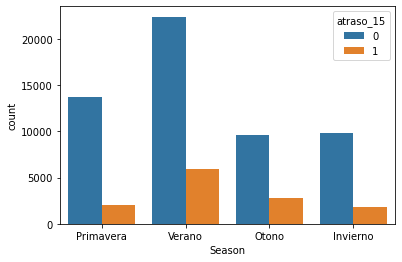

In [57]:
sns.countplot(x='Season', data=df, hue='atraso_15', order=['Primavera', 'Verano', 'Otono', 'Invierno'])

<AxesSubplot:xlabel='DIANOM', ylabel='count'>

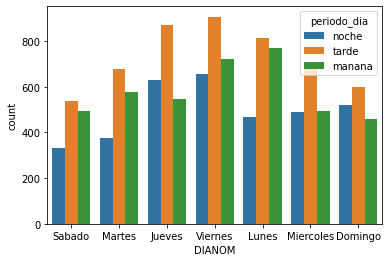

In [58]:
sns.countplot(x='DIANOM', hue=('periodo_dia'), data=df[df.atraso_15==1])

3.  C mo se compone la tasa de atraso por destino, aerol nea, mes del a o, d a de la semana, temporada, tipo de vuelo?
4.  Que  variables esperar as que m s influyeran en predecir atrasos?

In [40]:
df

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,OPERA,SIGLAORI,SIGLADES,ANO,temporada_alta,dif_min,atraso_15,periodo_dia,dif_nivel,Season
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,2017,1,3.0,0,noche,0,Invierno
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,2017,1,9.0,0,noche,0,Invierno
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,2017,1,9.0,0,noche,0,Invierno
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,2017,1,3.0,0,noche,0,Invierno
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,2017,1,-2.0,0,noche,0,Invierno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,2017,0,46.0,1,tarde,1,Otono
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,2017,0,16.0,1,tarde,1,Otono
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,2017,0,40.0,1,tarde,1,Otono
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,2017,0,13.0,0,tarde,0,Otono


# Label Encoder & Dummies

In [41]:
df['TIPOVUELO'] = labelencoder.fit_transform(df['TIPOVUELO'])
df['temporada_alta'] = labelencoder.fit_transform(df['temporada_alta'])
df['atraso_15'] = labelencoder.fit_transform(df['atraso_15'])


NameError: name 'labelencoder' is not defined

In [42]:
df_index = df.set_index('Fecha-I')
df_index

,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,...,OPERA,SIGLAORI,SIGLADES,ANO,temporada_alta,dif_min,atraso_15,periodo_dia,dif_nivel,Season
Fecha-I,,,,,,,,,,,,,,,,,,,,,
2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,...,American Airlines,Santiago,Miami,2017,1,3.0,0,noche,0,Invierno
2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,...,American Airlines,Santiago,Miami,2017,1,9.0,0,noche,0,Invierno
2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,...,American Airlines,Santiago,Miami,2017,1,9.0,0,noche,0,Invierno
2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,...,American Airlines,Santiago,Miami,2017,1,3.0,0,noche,0,Invierno
2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,...,American Airlines,Santiago,Miami,2017,1,-2.0,0,noche,0,Invierno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,...,JetSmart SPA,Santiago,Lima,2017,0,46.0,1,tarde,1,Otono
2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,...,JetSmart SPA,Santiago,Lima,2017,0,16.0,1,tarde,1,Otono
2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,...,JetSmart SPA,Santiago,Lima,2017,0,40.0,1,tarde,1,Otono


In [43]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,OPERA,SIGLAORI,SIGLADES,ANO,temporada_alta,dif_min,atraso_15,periodo_dia,dif_nivel,Season
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,2017,1,3.0,0,noche,0,Invierno
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,2017,1,9.0,0,noche,0,Invierno
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,2017,1,9.0,0,noche,0,Invierno
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,2017,1,3.0,0,noche,0,Invierno
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,2017,1,-2.0,0,noche,0,Invierno


In [691]:
sigla = 'SIGLAORI'

In [690]:
df_clean = df.drop(labels=['Fecha-I','Emp-O', 'Des-O', 'Fecha-O', 'Ori-O', 'OPERA', 'SIGLAORI', 'SIGLADES', 'dif_min' ], axis=1)

In [704]:
df_clean = df_clean.drop(labels=['Vlo-I', 'Vlo-O'], axis=1)

In [705]:
df_clean

,Ori-I,Des-I,Emp-I,DIA,MES,DIANOM,TIPOVUELO,ANO,temporada_alta,atraso_15,periodo_dia
0,SCEL,KMIA,AAL,1,1,Domingo,0,2017,1,0,noche
1,SCEL,KMIA,AAL,2,1,Lunes,0,2017,1,0,noche
2,SCEL,KMIA,AAL,3,1,Martes,0,2017,1,0,noche
3,SCEL,KMIA,AAL,4,1,Miercoles,0,2017,1,0,noche
4,SCEL,KMIA,AAL,5,1,Jueves,0,2017,1,0,noche
...,...,...,...,...,...,...,...,...,...,...,...
68201,SCEL,SPJC,JAT,22,12,Viernes,0,2017,0,1,tarde
68202,SCEL,SPJC,JAT,25,12,Lunes,0,2017,0,1,tarde
68203,SCEL,SPJC,JAT,27,12,Miercoles,0,2017,0,1,tarde
68204,SCEL,SPJC,JAT,29,12,Viernes,0,2017,0,0,tarde


In [706]:
pd1 = pd.get_dummies(data=df_clean, columns=['Des-I', 'Emp-I','Ori-I',
            'DIANOM', 'periodo_dia']) 

In [707]:
pd1

,DIA,MES,TIPOVUELO,ANO,temporada_alta,atraso_15,Des-I_CYYZ,Des-I_EGLL,Des-I_EGYP,Des-I_KATL,...,DIANOM_Domingo,DIANOM_Jueves,DIANOM_Lunes,DIANOM_Martes,DIANOM_Miercoles,DIANOM_Sabado,DIANOM_Viernes,periodo_dia_manana,periodo_dia_noche,periodo_dia_tarde
0,1,1,0,2017,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,2,1,0,2017,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,3,1,0,2017,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,4,1,0,2017,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,5,1,0,2017,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,22,12,0,2017,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
68202,25,12,0,2017,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
68203,27,12,0,2017,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
68204,29,12,0,2017,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [747]:
y = pd1['atraso_15']


In [748]:
X = pd1.drop(labels='atraso_15', axis=1)

# MODELO

In [749]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [750]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.33, random_state=42)

catboost

In [751]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.816
Accuracy score (validation): 0.813
Learning rate:  0.075
Accuracy score (training): 0.816
Accuracy score (validation): 0.813
Learning rate:  0.1
Accuracy score (training): 0.816
Accuracy score (validation): 0.813
Learning rate:  0.25
Accuracy score (training): 0.816
Accuracy score (validation): 0.813
Learning rate:  0.5
Accuracy score (training): 0.816
Accuracy score (validation): 0.813
Learning rate:  0.75
Accuracy score (training): 0.817
Accuracy score (validation): 0.813
Learning rate:  1
Accuracy score (training): 0.815
Accuracy score (validation): 0.812


In [778]:
gb_clf2 = GradientBoostingClassifier(n_estimators=30, learning_rate=0.5, max_features=9, max_depth=8, random_state=42)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[17839   455]
 [ 3721   493]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     18294
           1       0.52      0.12      0.19      4214

    accuracy                           0.81     22508
   macro avg       0.67      0.55      0.54     22508
weighted avg       0.77      0.81      0.76     22508



Text(0.5, 1.0, 'Variable Importance')

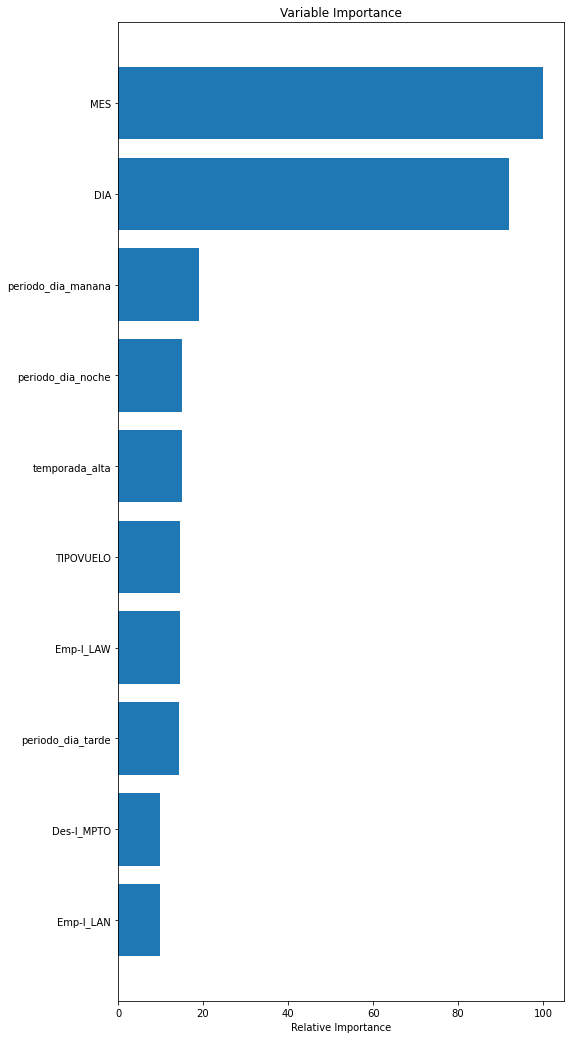

In [808]:
feature_importance = gb_clf2.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)


plt.figure(figsize=(8, 18))
plt.barh(pos[-10:], feature_importance[sorted_idx][-10:], align='center')


plt.yticks(pos[-10:], X.keys()[sorted_idx][-10:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')


# a

<BarContainer object of 110 artists>

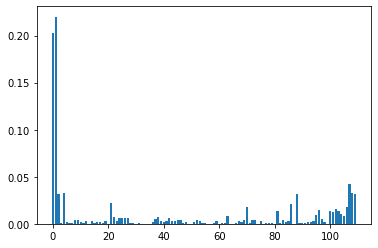

In [786]:
plt.bar(range(len(gb_clf2.feature_importances_)), gb_clf2.feature_importances_)


In [62]:
import session_info

ModuleNotFoundError: No module named 'session_info'

In [67]:
!pip freeze > requirements.txt